# I- Corrélation entre attributs et suppression manuelle de quelques features


In [ ]:
%pip install pandas

In [ ]:
%pip install matplotlib

In [ ]:
%pip install jinja2

In [ ]:
%pip install sklearn

In [ ]:
%pip install seaborn

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

df = pd.read_csv('../df.csv')

enc = preprocessing.LabelEncoder()
#convertit en numérique les colonnes

for column_name in df:
    if not column_name.isnumeric():
        df[column_name] = enc.fit_transform(df[column_name])


df.info()
df
#matrice de correlation
corr_df = df.corr(method='pearson')

plt.figure(figsize=(15, 10))
sns.heatmap(round(corr_df,2), annot=True)
plt.xticks(rotation=90)
plt.show()

#supprimer colonne
del df['Num_Acc']
del df['num_veh']
del df['id_usa']
del df['ville']
del df['id_code_insee']
del df['descr_athmo']
del df['descr_lum']
del df['descr_etat_surf']
del df['description_intersection']
del df['an_nais']
del df['age']
del df['descr_motif_traj']
del df['descr_type_col']
del df['region']
del df['departement']

corr_df = df.corr(method='pearson')

plt.figure(figsize=(15, 10))
sns.heatmap(round(corr_df,2), annot=True)
plt.xticks(rotation=90)
plt.show()
#del df['nom colonne']


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

accidents = pd.read_csv('../df.csv')
df = pd.DataFrame(accidents)
df.info()
df.drop((df[(df['num_veh'])]).index, inplace=True)
accidents.info()
corr_df = accidents.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

# Partionnement ( Clustering )

## k-means from scikit-learn

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


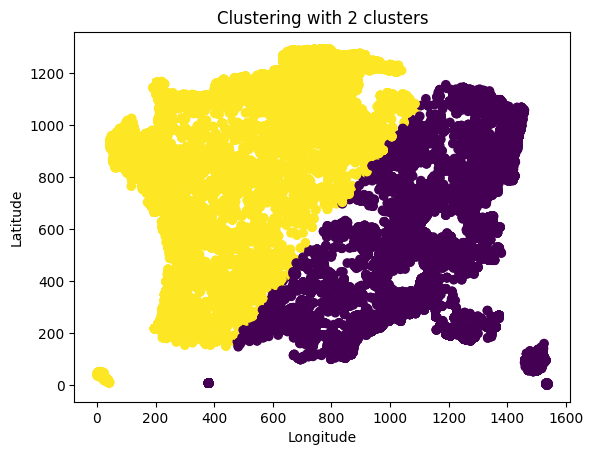

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


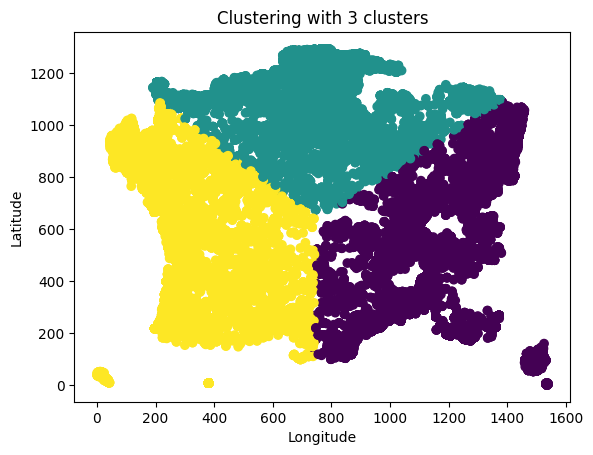

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


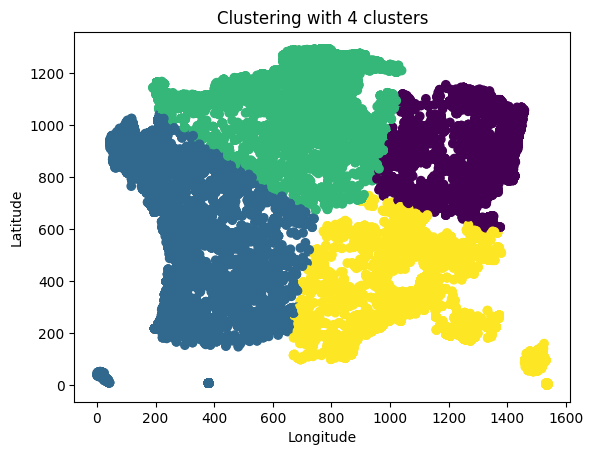

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


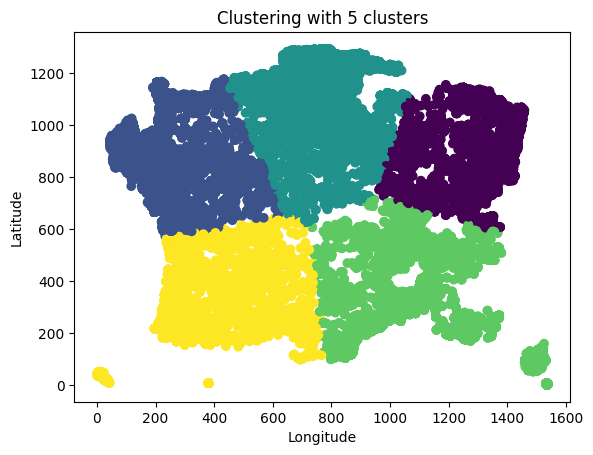

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


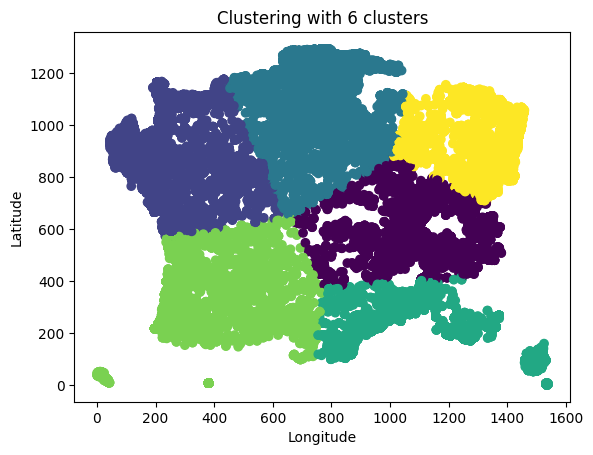

In [8]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Charger les données (latitude, longitude) dans un DataFrame
data = df[['latitude', 'longitude']]

# Liste des nombres de clusters à tester
n_clusters = [2, 3, 4, 5, 6]

# Effectuer le clustering pour chaque nombre de clusters
for n in n_clusters:
    # Instancier le modèle K-means
    kmeans = KMeans(n_clusters=n, random_state=42)
    
    # Effectuer le clustering
    kmeans.fit(data)
    
    # Assigner les clusters aux points de données
    labels = kmeans.labels_
    
    # Afficher le résultat du clustering
    plt.scatter(data['longitude'], data['latitude'], c=labels)
    plt.title(f"Clustering with {n} clusters")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

## k-means from scratch

In [5]:
import matplotlib.pyplot as plt


In [6]:
def Kmeans(centroids,df):
    df = df[['latitude','longitude']]
    fig = plt.figure(figsize=(16,12))  # Width: 8 inches, Height: 6 inches
    plt.scatter(df['latitude'],df['longitude'],s=10)
    #randomly inti k centroids


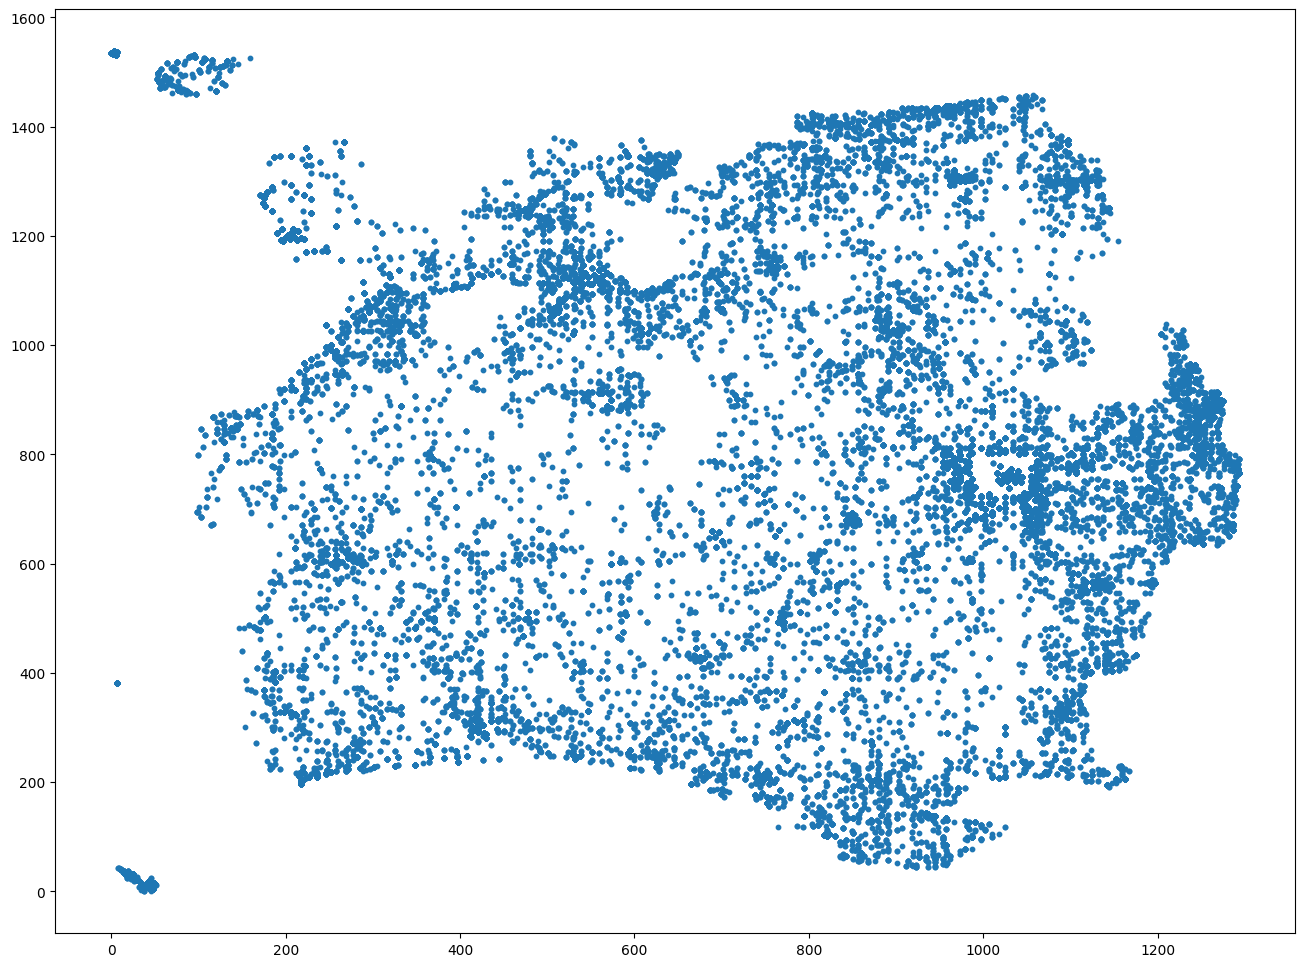

In [7]:
Kmeans(4,df)